=== Flight Delay Prediction System ===
Original dataset size: 1201664 rows
Data stratified sampled to 91528 rows across 212 year-carrier combinations
Proportion of delayed flights: 17.06%

=== Seasonal Delay Analysis ===
Delay rates by season:
  Summer: 20.00%
  Winter: 18.61%
  Spring: 16.39%
  Fall: 13.17%


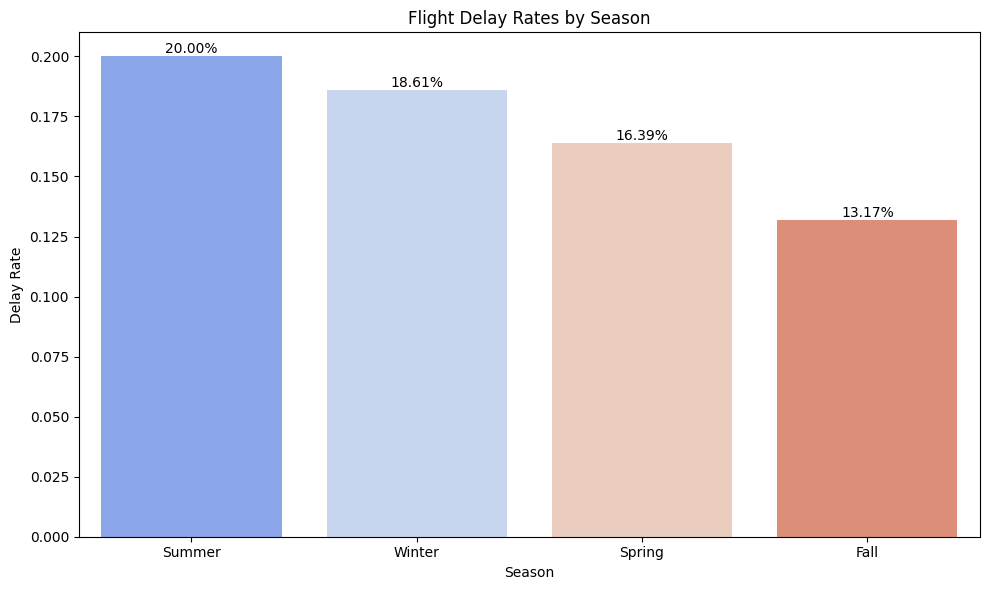

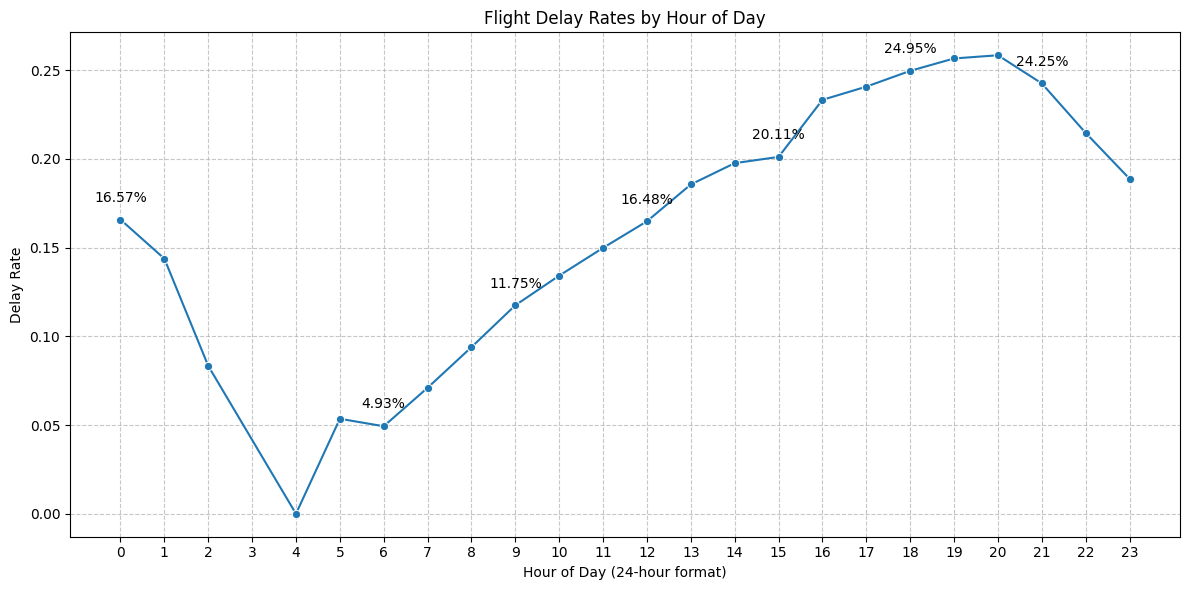


Best times to fly (lowest delay rates):
  4:00 - 0.00% delay rate
  6:00 - 4.93% delay rate
  5:00 - 5.35% delay rate

Worst times to fly (highest delay rates):
  20:00 - 25.83% delay rate
  19:00 - 25.65% delay rate
  18:00 - 24.95% delay rate

Top 5 Airlines (lowest delay rates):
  HA: 10.32%
  US: 13.25%
  AS: 13.60%
  DL: 14.13%
  MQ: 14.59%

Bottom 5 Airlines (highest delay rates):
  UA: 18.67%
  AA: 18.93%
  WN: 20.17%
  B6: 20.81%
  EV: 22.02%


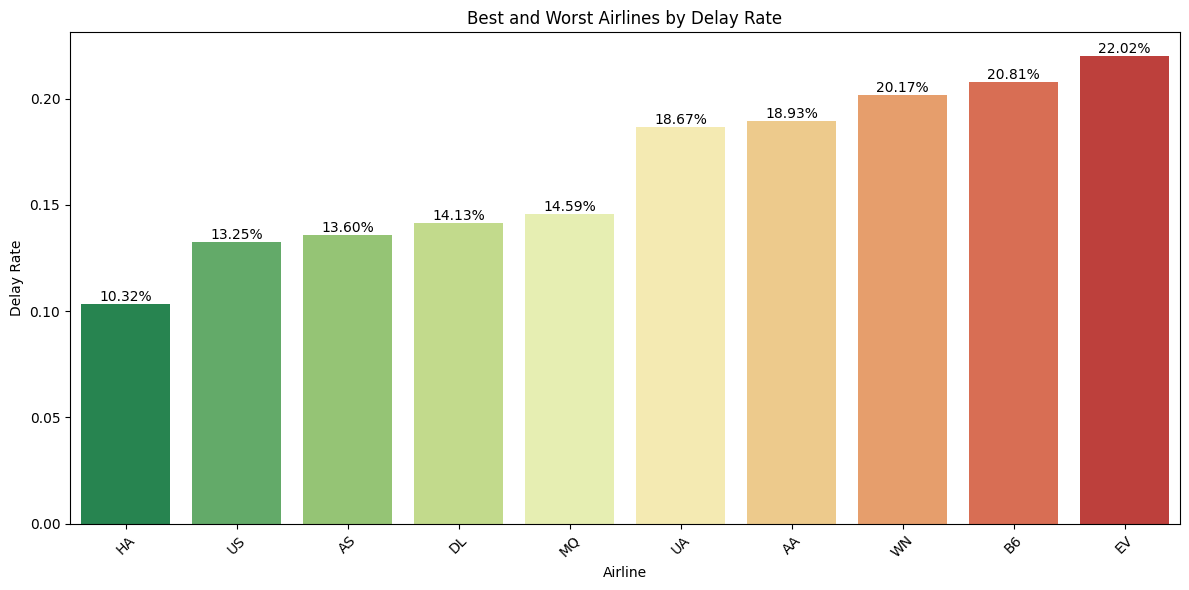


Extracting feature importance...

=== Top 10 Features ===
1. scheduledhour: 0.2250
2. route_delay_rate: 0.1720
3. windspeed: 0.0624
4. uniquecarrier_EV: 0.0444
5. season_Summer: 0.0435
6. season_Fall: 0.0352
7. temperature: 0.0336
8. uniquecarrier_B6: 0.0274
9. dest_EWR: 0.0224
10. origin_ORD: 0.0196


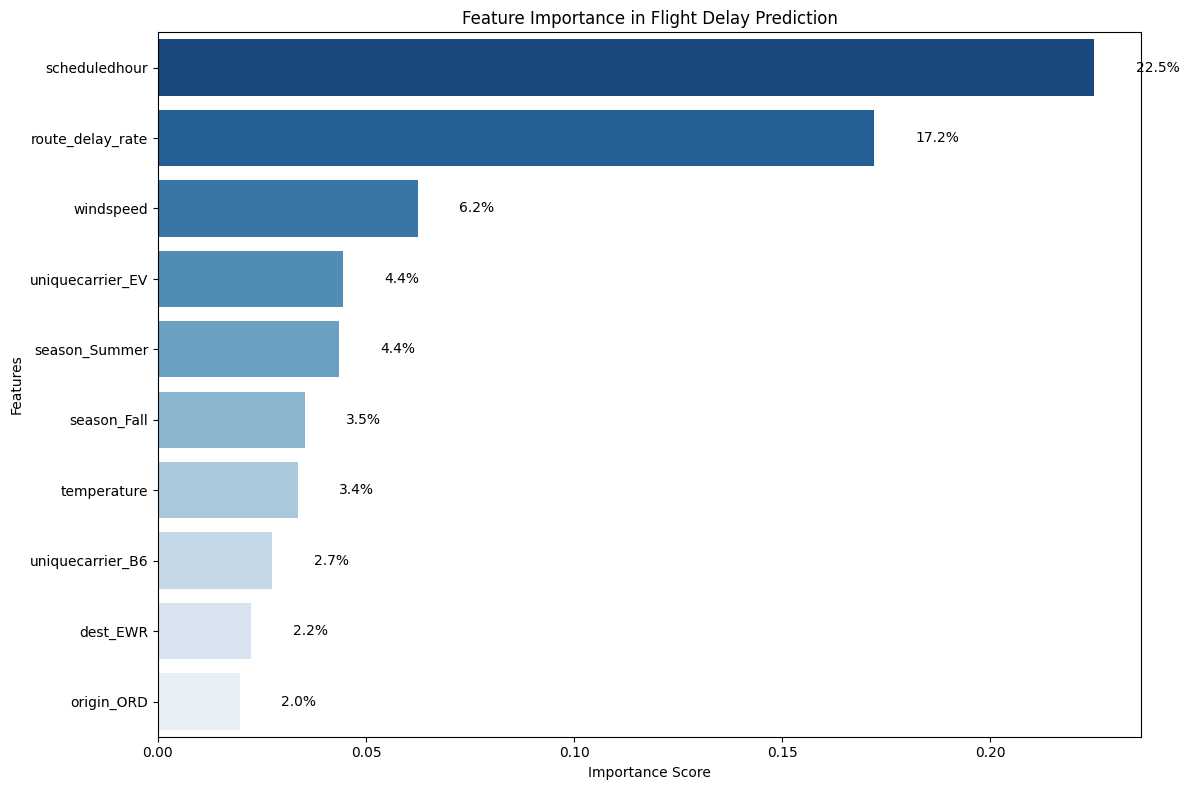


=== Training Logistic Regression ===
Logistic Regression Accuracy: 0.6729
ROC AUC Score: 0.7269

=== Training K-Nearest Neighbors ===
K-Nearest Neighbors Accuracy: 0.8028
ROC AUC Score: 0.5592

=== Training Random Forest ===
Random Forest Accuracy: 0.8294
ROC AUC Score: 0.6895

=== Training Gradient Boosting ===
Gradient Boosting Accuracy: 0.8337
ROC AUC Score: 0.7359

=== Training Decision Tree ===
Decision Tree Accuracy: 0.8328
ROC AUC Score: 0.7216

=== Training Naive Bayes ===
Naive Bayes Accuracy: 0.4672
ROC AUC Score: 0.5651

Best performing model: Gradient Boosting
ROC AUC: 0.7359
Accuracy: 0.8337

=== Testing Model on Known Delayed Flights ===
Found actual route delay rate for MDW-RDU: 0.375
Found actual route delay rate for ATL-RDU: 0.180
Found actual route delay rate for STL-RDU: 0.000

=== Flight Delay Predictions using Gradient Boosting ===

Testing on Known Delayed Flights:
1. Southwest: 9:05 PM (MDW-RDU, WN606)
   Actual Status: Delayed
   Predicted Status: Delayed
   De

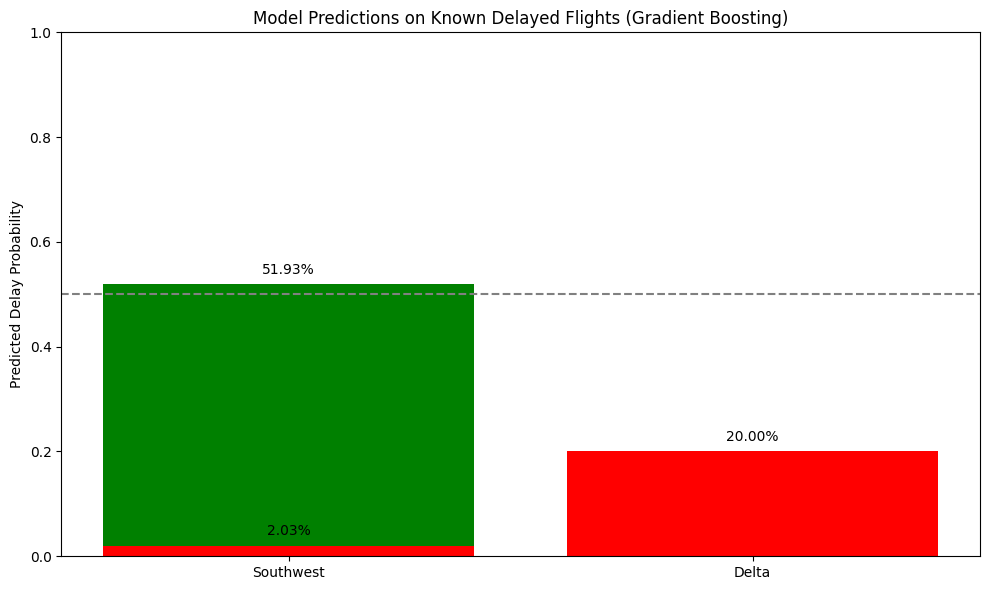

<Figure size 1200x600 with 0 Axes>

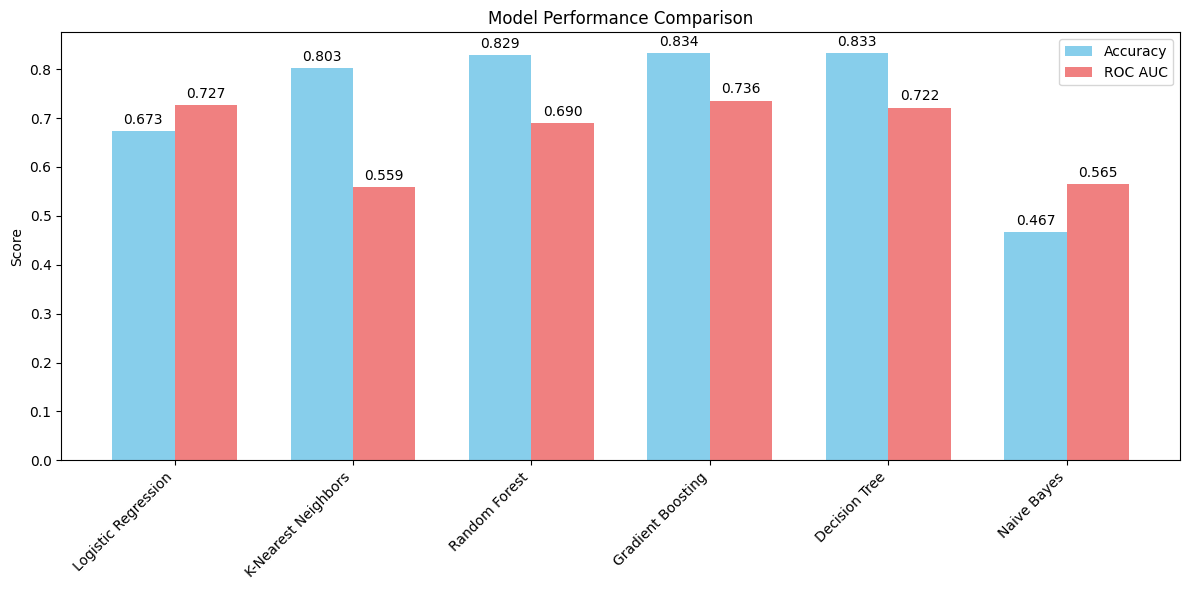

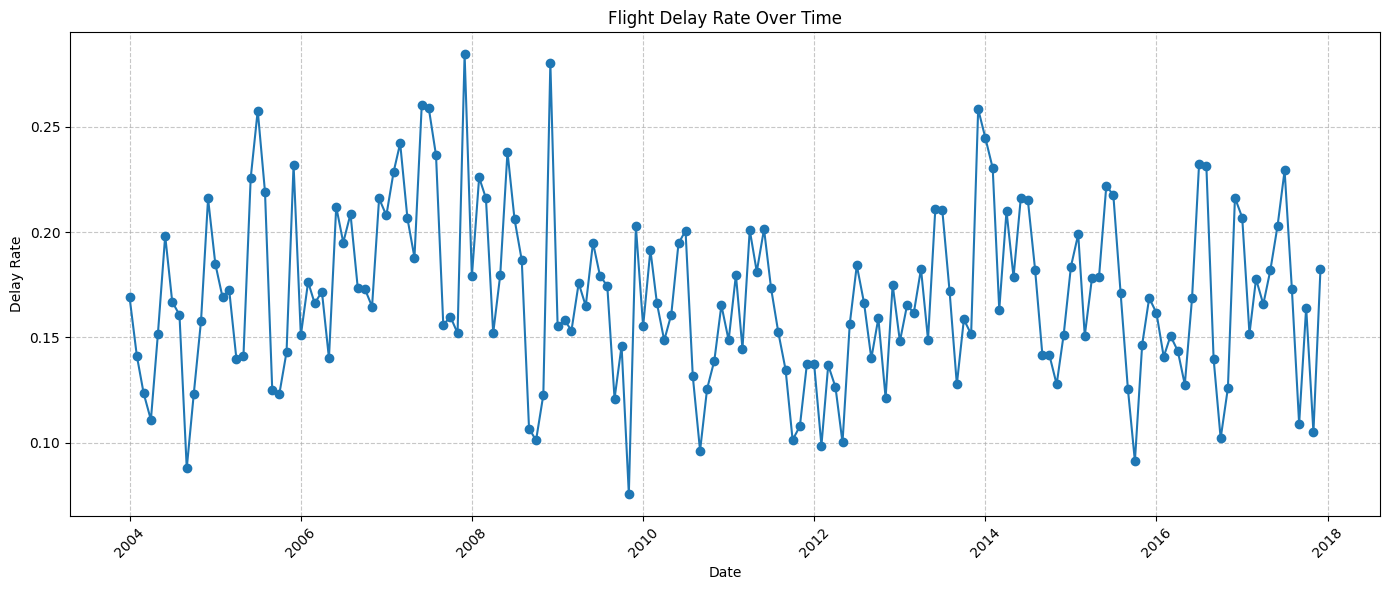

                     Accuracy  Precision  Recall  F1 Score
Logistic Regression    0.6729     0.2939  0.6539    0.4055
Naive Bayes            0.4672     0.1959  0.6836    0.3045
K-Nearest Neighbors    0.8028     0.2429  0.0736    0.1130
Gradient Boosting      0.8337     0.7047  0.0435    0.0820
Decision Tree          0.8328     0.9306  0.0215    0.0419
Random Forest          0.8294     0.0000  0.0000    0.0000


In [ ]:
# Code for Presentation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import warnings
import datetime
warnings.filterwarnings('ignore')

def comprehensive_flight_delay_prediction(data_path='DelayData.csv', sample_size=100000):
    # 1. Data Loading and Preprocessing
    print("=== Flight Delay Prediction System ===")

    # Load data
    df = pd.read_csv(data_path)
    df.columns = df.columns.str.lower()

    print(f"Original dataset size: {len(df)} rows")

    # More sophisticated sampling: ensure diversity across years, carriers and seasons
    if len(df) > sample_size:
        has_datetime = False
        if 'scheduleddepartdatetime' in df.columns:
            df['scheduleddepartdatetime'] = pd.to_datetime(df['scheduleddepartdatetime'], errors='coerce')
            df['year'] = df['scheduleddepartdatetime'].dt.year
            has_datetime = True
        elif 'year' in df.columns:
            has_datetime = True

        # Stratified sampling based on carrier and year
        if has_datetime and 'uniquecarrier' in df.columns:
            # Create a stratification column
            df['strat'] = df['uniquecarrier'] + '_' + df['year'].astype(str)

            # Get a list of all strata
            strata = df['strat'].unique()

            # Calculate samples per stratum
            samples_per_stratum = max(1, int(sample_size / len(strata)))

            # Sample from each stratum
            sampled_dfs = []
            for stratum in strata:
                stratum_df = df[df['strat'] == stratum]
                # If stratum is smaller than needed samples, take all rows
                if len(stratum_df) <= samples_per_stratum:
                    sampled_dfs.append(stratum_df)
                else:
                    sampled_dfs.append(stratum_df.sample(n=samples_per_stratum, random_state=42))

            # Combine all samples
            df = pd.concat(sampled_dfs)
            df = df.drop(columns=['strat'])

            print(f"Data stratified sampled to {len(df)} rows across {len(strata)} year-carrier combinations")
        else:
            # Fall back to random sampling
            df = df.sample(n=sample_size, random_state=42)
            print(f"Data randomly sampled to {sample_size} rows")

    # Create delay indicator
    if 'depdelay' not in df.columns:
        print("Error: 'depdelay' column not found")
        return

    df['isdelayed'] = (df['depdelay'] > 15).astype(int)
    print(f"Proportion of delayed flights: {df['isdelayed'].mean():.2%}")

    # 2. Feature Engineering
    leak_cols = [col for col in df.columns if 'delay' in col.lower() and col != 'isdelayed']
    df = df.drop(columns=leak_cols)

    df = df.fillna(df.median(numeric_only=True))

    if 'month' in df.columns:
        df['season'] = df['month'].map({
            1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
            5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
            9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'
        })

    if 'dayofweek' in df.columns:
        df['weekend'] = df['dayofweek'].isin([6, 7]).astype(int)

    if 'origin' in df.columns and 'dest' in df.columns:
        route_delay = df.groupby(['origin', 'dest'])['isdelayed'].mean().reset_index()
        route_delay.columns = ['origin', 'dest', 'route_delay_rate']
        df = pd.merge(df, route_delay, on=['origin', 'dest'], how='left')
        df['route_delay_rate'] = df['route_delay_rate'].fillna(df['isdelayed'].mean())

    # 3. Enhanced Data Analysis - Seasonal Patterns
    print("\n=== Seasonal Delay Analysis ===")
    if 'season' in df.columns:
        season_delays = df.groupby('season')['isdelayed'].mean().sort_values(ascending=False)
        print("Delay rates by season:")
        for season, rate in season_delays.items():
            print(f"  {season}: {rate:.2%}")

        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=season_delays.index, y=season_delays.values, palette='coolwarm')
        plt.title('Flight Delay Rates by Season')
        plt.xlabel('Season')
        plt.ylabel('Delay Rate')

        # Add percentage labels on bars
        for i, p in enumerate(ax.patches):
            ax.annotate(f"{p.get_height():.2%}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    # Time of Day Analysis
    if 'scheduledhour' in df.columns:
        hour_delays = df.groupby('scheduledhour')['isdelayed'].mean()

        plt.figure(figsize=(12, 6))
        ax = sns.lineplot(x=hour_delays.index, y=hour_delays.values, marker='o')
        plt.title('Flight Delay Rates by Hour of Day')
        plt.xlabel('Hour of Day (24-hour format)')
        plt.ylabel('Delay Rate')
        plt.xticks(range(0, 24))
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add percentage labels at key points
        for i, v in hour_delays.items():
            if i % 3 == 0:  # Label every 3 hours to avoid crowding
                plt.text(i, v + 0.01, f"{v:.2%}", ha='center')

        plt.tight_layout()
        plt.show()

        # Find best and worst times to fly
        best_hours = hour_delays.nsmallest(3)
        worst_hours = hour_delays.nlargest(3)

        print("\nBest times to fly (lowest delay rates):")
        for hour, rate in best_hours.items():
            print(f"  {hour}:00 - {rate:.2%} delay rate")

        print("\nWorst times to fly (highest delay rates):")
        for hour, rate in worst_hours.items():
            print(f"  {hour}:00 - {rate:.2%} delay rate")

    # Carrier Analysis
    if 'uniquecarrier' in df.columns:
        # Only include carriers with at least 100 flights
        carrier_counts = df['uniquecarrier'].value_counts()
        valid_carriers = carrier_counts[carrier_counts >= 100].index

        carrier_df = df[df['uniquecarrier'].isin(valid_carriers)]
        carrier_delays = carrier_df.groupby('uniquecarrier')['isdelayed'].mean().sort_values()

        # Get top 5 and bottom 5 carriers
        top5_carriers = carrier_delays.head(5)
        bottom5_carriers = carrier_delays.tail(5)

        print("\nTop 5 Airlines (lowest delay rates):")
        for carrier, rate in top5_carriers.items():
            print(f"  {carrier}: {rate:.2%}")

        print("\nBottom 5 Airlines (highest delay rates):")
        for carrier, rate in bottom5_carriers.items():
            print(f"  {carrier}: {rate:.2%}")

        plt.figure(figsize=(12, 6))
        combined = pd.concat([top5_carriers, bottom5_carriers])
        ax = sns.barplot(x=combined.index, y=combined.values, palette='RdYlGn_r')
        plt.title('Best and Worst Airlines by Delay Rate')
        plt.xlabel('Airline')
        plt.ylabel('Delay Rate')
        plt.xticks(rotation=45)

        # Add percentage labels on bars
        for i, p in enumerate(ax.patches):
            ax.annotate(f"{p.get_height():.2%}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    # 4. Feature Selection
    categorical_features = ['season', 'uniquecarrier', 'origin', 'dest']
    numerical_features = ['scheduledhour', 'distance', 'windspeed', 'temperature',
                         'weekend', 'route_delay_rate']

    categorical_features = [f for f in categorical_features if f in df.columns]
    numerical_features = [f for f in numerical_features if f in df.columns]

    # Preprocess data
    X_prep = df[categorical_features + numerical_features].copy()
    y = df['isdelayed']

    # Create dummy variables for categorical features
    for col in categorical_features:
        if col in X_prep.columns:
            dummies = pd.get_dummies(X_prep[col], prefix=col)
            X_prep = pd.concat([X_prep, dummies], axis=1)
            X_prep = X_prep.drop(columns=[col])

    # 5. Train Random Forest to get feature importance
    print("\nExtracting feature importance...")
    rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
    rf_model.fit(X_prep, y)

    # Get feature importances
    feature_importances = dict(zip(X_prep.columns, rf_model.feature_importances_))
    feature_importances = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))

    # Get Top 10 features
    top_10_features = list(feature_importances.keys())[:10]
    print("\n=== Top 10 Features ===")
    for i, (feature, importance) in enumerate(list(feature_importances.items())[:10], 1):
        print(f"{i}. {feature}: {importance:.4f}")

    # 6. Plot feature importance
    plt.figure(figsize=(12, 8))
    features = list(feature_importances.keys())[:10]
    importances = list(feature_importances.values())[:10]
    sns.barplot(x=importances, y=features, palette='Blues_r')
    plt.title('Feature Importance in Flight Delay Prediction')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')

    # Add percentage values to the bars
    for i, imp in enumerate(importances):
        total_importance = sum(list(feature_importances.values()))
        percentage = imp / total_importance * 100
        plt.text(imp + 0.01, i, f'{percentage:.1f}%', va='center')

    plt.tight_layout()
    plt.show()

    # 7. Train-test split using the full feature set
    X_train, X_test, y_train, y_test = train_test_split(
        X_prep, y, test_size=0.2, random_state=42, stratify=y)

    # 8. Model definitions with two additional models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
        'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42),
        'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
        'Naive Bayes': GaussianNB()
    }

    # 9. Model training and evaluation
    results = {}
    roc_aucs = {}
    models_trained = {}

    for model_name, model in models.items():
        print(f"\n=== Training {model_name} ===")

        model.fit(X_train, y_train)
        models_trained[model_name] = model

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        results[model_name] = accuracy

        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        roc_aucs[model_name] = roc_auc

        print(f"{model_name} Accuracy: {accuracy:.4f}")
        print(f"ROC AUC Score: {roc_auc:.4f}")

    # 10. Find best model
    best_model_name = max(roc_aucs, key=roc_aucs.get)
    best_model = models_trained[best_model_name]
    print(f"\nBest performing model: {best_model_name}")
    print(f"ROC AUC: {roc_aucs[best_model_name]:.4f}")
    print(f"Accuracy: {results[best_model_name]:.4f}")

    # 11. Predict on recently confirmed delayed flights
    print("\n=== Testing Model on Known Delayed Flights ===")

    # First, calculate actual route_delay_rates from the data
    route_delay_lookup = df.groupby(['origin', 'dest'])['isdelayed'].mean().reset_index()
    route_delay_lookup.columns = ['origin', 'dest', 'route_delay_rate']

    # Create test flights with actual route delay rates
    known_delayed_flights = [
        {
            'scheduledhour': 21,             # 9:00 PM (WN606 scheduled departure time 21:05 CDT)
            'distance': 599,                 # MDW-RDU distance in miles
            'uniquecarrier': 'WN',           # Southwest Airlines
            'origin': 'MDW',                 # Chicago Midway
            'dest': 'RDU',                   # Raleigh-Durham
            'season': 'Spring',              # April = Spring
            'weekend': 1,                    # Sunday (2025-04-06)
            'temperature': 8.5,              # Weekly average temperature (Celsius)
            'windspeed': 14.5,               # Weekly average wind speed (km/h)
            'actual_delay': 'Delayed'        # Known to have been delayed
        },
        {
            'scheduledhour': 22,             # 10:00 PM (DL955 scheduled departure time 22:37 EDT)
            'distance': 356,                 # ATL-RDU distance in miles
            'uniquecarrier': 'DL',           # Delta Airlines
            'origin': 'ATL',                 # Atlanta
            'dest': 'RDU',                   # Raleigh-Durham
            'season': 'Spring',              # April = Spring
            'weekend': 0,                    # Monday (2025-04-07)
            'temperature': 22.7,             # Weekly average temperature
            'windspeed': 10.5,               # Weekly average wind speed
            'actual_delay': 'Delayed'        # Known to have been delayed
        },
        {
            'scheduledhour': 21,             # 9:00 PM (WN3976 scheduled departure time 21:40 CDT)
            'distance': 666,                 # STL-RDU distance in miles
            'uniquecarrier': 'WN',           # Southwest Airlines
            'origin': 'STL',                 # St. Louis
            'dest': 'RDU',                   # Raleigh-Durham
            'season': 'Spring',              # April = Spring
            'weekend': 1,                    # Sunday (2025-04-06)
            'temperature': 11.0,             # Weekly average temperature
            'windspeed': 15.0,               # Weekly average wind speed
            'actual_delay': 'Delayed'        # Known to have been delayed
        }
    ]

    # Dynamically look up and fill in the route_delay_rate for each test flight
    default_delay_rate = df['isdelayed'].mean()

    for flight in known_delayed_flights:
        matching_route = route_delay_lookup[
            (route_delay_lookup['origin'] == flight['origin']) &
            (route_delay_lookup['dest'] == flight['dest'])
        ]
        if not matching_route.empty:
            flight['route_delay_rate'] = matching_route['route_delay_rate'].values[0]
            print(f"Found actual route delay rate for {flight['origin']}-{flight['dest']}: {flight['route_delay_rate']:.3f}")
        else:
            flight['route_delay_rate'] = default_delay_rate
            print(f"No data for route {flight['origin']}-{flight['dest']}, using default rate: {default_delay_rate:.3f}")

    flight_descriptions = [
        "Southwest: 9:05 PM (MDW-RDU, WN606)",
        "Delta: 10:37 PM (ATL-RDU, DL955)",
        "Southwest: 9:40 PM (STL-RDU, WN3976)"
    ]

    # Create DataFrame
    flights_df = pd.DataFrame(known_delayed_flights)
    actual_outcomes = flights_df['actual_delay'].copy()
    flights_df = flights_df.drop(columns=['actual_delay'])

    # Create same feature format as model training
    flights_X = flights_df.copy()

    # Create dummy variables for categorical features
    for col in categorical_features:
        if col in flights_X.columns:
            dummies = pd.get_dummies(flights_X[col], prefix=col)
            flights_X = pd.concat([flights_X, dummies], axis=1)
            flights_X = flights_X.drop(columns=[col])

    # Ensure all training features exist
    for feature in X_train.columns:
        if feature not in flights_X.columns:
            flights_X[feature] = 0

    # Select only features in the training data
    flights_X = flights_X[X_train.columns]

    # Make predictions with best model only
    predictions = best_model.predict(flights_X)
    probabilities = best_model.predict_proba(flights_X)[:,1]

    # Create results table
    results_table = []
    for i, (desc, pred, prob, actual) in enumerate(zip(flight_descriptions, predictions, probabilities, actual_outcomes)):
        correct_prediction = (pred == 1 and actual == 'Delayed') or (pred == 0 and actual == 'On-time')

        results_table.append({
            'Flight': desc,
            'Actual Status': actual,
            'Predicted Status': 'Delayed' if pred == 1 else 'On-time',
            'Delay Probability': f"{prob:.2%}",
            'Correct Prediction': 'Yes' if correct_prediction else 'No'
        })

    # Display prediction results
    print(f"\n=== Flight Delay Predictions using {best_model_name} ===")
    print("\nTesting on Known Delayed Flights:")

    correct_count = 0
    for i, result in enumerate(results_table, 1):
        correct_count += 1 if result['Correct Prediction'] == 'Yes' else 0
        print(f"{i}. {result['Flight']}")
        print(f"   Actual Status: {result['Actual Status']}")
        print(f"   Predicted Status: {result['Predicted Status']}")
        print(f"   Delay Probability: {result['Delay Probability']}")
        print(f"   Correct Prediction? {result['Correct Prediction']}")
        print()

    accuracy = correct_count / len(results_table)
    print(f"Overall Accuracy on Known Delayed Flights: {accuracy:.2%}")

    # Plot prediction results
    plt.figure(figsize=(10, 6))

    # Extract airline names for plotting
    airlines = [desc.split(':')[0] for desc in flight_descriptions]

    # Create bar colors based on correct predictions
    bar_colors = ['green' if result['Correct Prediction'] == 'Yes' else 'red' for result in results_table]

    bars = plt.bar(airlines, probabilities, color=bar_colors)

    # Add probability labels on bars
    for bar, prob in zip(bars, probabilities):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f"{prob:.2%}", ha='center')

    plt.axhline(y=0.5, color='gray', linestyle='--', label='Delay Threshold')
    plt.ylabel('Predicted Delay Probability')
    plt.title(f'Model Predictions on Known Delayed Flights ({best_model_name})')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # Additional model comparison plot
    plt.figure(figsize=(12, 6))

    model_names = list(roc_aucs.keys())
    accuracies = [results[name] for name in model_names]
    roc_values = [roc_aucs[name] for name in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
    rects2 = ax.bar(x + width/2, roc_values, width, label='ROC AUC', color='lightcoral')

    ax.set_title('Model Performance Comparison')
    ax.set_ylabel('Score')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.legend()

    # Add value labels to the bars
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)

    fig.tight_layout()
    plt.show()

    # Time series visualization
    if 'year' in df.columns and 'month' in df.columns:
        # Create a time series of delay rates
        df['yearmonth'] = df['year'].astype(int).astype(str) + '-' + df['month'].astype(int).astype(str).str.zfill(2)
        monthly_delays = df.groupby('yearmonth')['isdelayed'].mean().reset_index()
        monthly_delays['date'] = pd.to_datetime(monthly_delays['yearmonth'])
        monthly_delays = monthly_delays.sort_values('date')

        plt.figure(figsize=(14, 6))
        plt.plot(monthly_delays['date'], monthly_delays['isdelayed'], marker='o', linestyle='-')
        plt.title('Flight Delay Rate Over Time')
        plt.xlabel('Date')
        plt.ylabel('Delay Rate')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return {
        'best_model': best_model,
        'best_model_name': best_model_name,
        'feature_importances': feature_importances,
        'predictions': predictions,
        'probabilities': probabilities,
        'results_table': results_table,
        'model_accuracy_on_delayed': accuracy,
        'all_models_accuracy': results,
        'all_models_roc_auc': roc_aucs,
        'models_trained': models_trained,
        'X_test': X_test,
        'y_test': y_test
    }

from sklearn.metrics import precision_score, recall_score, f1_score

# Call the function and capture outputs
results_dict = comprehensive_flight_delay_prediction()

models_trained = results_dict['models_trained']
X_test = results_dict['X_test']
y_test = results_dict['y_test']

# Compute extended metrics
extended_metrics = {}

for model_name, model in models_trained.items():
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    extended_metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Display as DataFrame
metrics_df = pd.DataFrame(extended_metrics).T.sort_values(by='F1 Score', ascending=False)
print(metrics_df.round(4))

In [ ]:
#MIGUEL Accuracy Improvement CODE

def comprehensive_flight_delay_prediction(data_path='DelayData.csv', sample_size=100000):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
    import warnings
    warnings.filterwarnings('ignore')

    # Load data
    df = pd.read_csv(data_path)
    df.columns = df.columns.str.lower()
    print(f"Original dataset size: {len(df)} rows")

    # Create delay indicator
    if 'depdelay' not in df.columns:
        print("Error: 'depdelay' column not found")
        return

    df['isdelayed'] = (df['depdelay'] > 15).astype(int)

    # Parse datetime and extract year if needed
    if 'scheduleddepartdatetime' in df.columns and 'year' not in df.columns:
        df['scheduleddepartdatetime'] = pd.to_datetime(df['scheduleddepartdatetime'], errors='coerce')
        df['year'] = df['scheduleddepartdatetime'].dt.year

    # Drop rows missing key stratification variables
    df = df.dropna(subset=['year', 'uniquecarrier'])
    df['strat'] = df['uniquecarrier'] + '_' + df['year'].astype(int).astype(str)

    # Split into delayed and non-delayed groups
    delayed_df = df[df['isdelayed'] == 1].copy()
    non_delayed_df = df[df['isdelayed'] == 0].copy()
    target_per_class = sample_size // 2

    def stratified_sample(group_df, label, target_size):
        strat_counts = group_df['strat'].value_counts()
        num_strata = len(strat_counts)
        samples_per_stratum = max(1, target_size // num_strata)
        sampled_list = []
        for stratum, count in strat_counts.items():
            stratum_df = group_df[group_df['strat'] == stratum]
            n = min(samples_per_stratum, len(stratum_df))
            sampled_list.append(stratum_df.sample(n=n, random_state=42))
        result_df = pd.concat(sampled_list).sample(frac=1, random_state=42)
        print(f"{label}: Sampled {len(result_df)} rows across {num_strata} strata")
        return result_df.drop(columns=['strat'])

    # Sample from each group
    delayed_sample = stratified_sample(delayed_df, "Delayed", target_per_class)
    non_delayed_sample = stratified_sample(non_delayed_df, "Non-delayed", target_per_class)

    # Match final sizes in case one class is smaller
    final_size = min(len(delayed_sample), len(non_delayed_sample))
    delayed_sample = delayed_sample.sample(n=final_size, random_state=42)
    non_delayed_sample = non_delayed_sample.sample(n=final_size, random_state=42)

    # Combine and shuffle
    df = pd.concat([delayed_sample, non_delayed_sample]).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"Final balanced dataset: {len(df)} rows ({final_size} delayed, {final_size} non-delayed)")

    # Feature Engineering
    leak_cols = [col for col in df.columns if 'delay' in col.lower() and col != 'isdelayed']
    df = df.drop(columns=leak_cols)
    df = df.fillna(df.median(numeric_only=True))

    if 'month' in df.columns:
        df['season'] = df['month'].map({
            1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
            5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
            9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'
        })

    if 'dayofweek' in df.columns:
        df['weekend'] = df['dayofweek'].isin([6, 7]).astype(int)

    if 'origin' in df.columns and 'dest' in df.columns:
        route_delay = df.groupby(['origin', 'dest'])['isdelayed'].mean().reset_index()
        route_delay.columns = ['origin', 'dest', 'route_delay_rate']
        df = pd.merge(df, route_delay, on=['origin', 'dest'], how='left')
        df['route_delay_rate'] = df['route_delay_rate'].fillna(df['isdelayed'].mean())

    # Feature Selection
    categorical_features = ['season', 'uniquecarrier', 'origin', 'dest']
    numerical_features = ['scheduledhour', 'distance', 'windspeed', 'temperature',
                         'weekend', 'route_delay_rate']
    categorical_features = [f for f in categorical_features if f in df.columns]
    numerical_features = [f for f in numerical_features if f in df.columns]

    X_prep = df[categorical_features + numerical_features].copy()
    y = df['isdelayed']

    for col in categorical_features:
        if col in X_prep.columns:
            dummies = pd.get_dummies(X_prep[col], prefix=col)
            X_prep = pd.concat([X_prep, dummies], axis=1)
            X_prep = X_prep.drop(columns=[col])

    # Feature Importance
    print("\nExtracting feature importance...")
    rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
    rf_model.fit(X_prep, y)
    feature_importances = dict(zip(X_prep.columns, rf_model.feature_importances_))
    feature_importances = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))

    top_10_features = list(feature_importances.keys())[:10]
    print("\n=== Top 10 Features ===")
    for i, (feature, importance) in enumerate(list(feature_importances.items())[:10], 1):
        print(f"{i}. {feature}: {importance:.4f}")

    # Model Training and Evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X_prep, y, test_size=0.2, random_state=42, stratify=y)

    models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,  # Increased from 50
        max_depth=10,      # Increased from 5
        min_samples_leaf=1,
        min_samples_split=2,
        class_weight='balanced',  # Added class weight
        n_jobs=-1,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Naive Bayes': GaussianNB()
    }

    results = {}
    roc_aucs = {}
    models_trained = {}

    for model_name, model in models.items():
        print(f"\n=== Training {model_name} ===")
        model.fit(X_train, y_train)
        models_trained[model_name] = model
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[model_name] = accuracy
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        roc_aucs[model_name] = roc_auc
        print(f"{model_name} Accuracy: {accuracy:.4f}")
        print(f"ROC AUC Score: {roc_auc:.4f}")

    best_model_name = max(roc_aucs, key=roc_aucs.get)
    best_model = models_trained[best_model_name]
    print(f"\nBest performing model: {best_model_name}")
    print(f"ROC AUC: {roc_aucs[best_model_name]:.4f}")
    print(f"Accuracy: {results[best_model_name]:.4f}")

    return {
        'best_model': best_model,
        'best_model_name': best_model_name,
        'feature_importances': feature_importances,
        'all_models_accuracy': results,
        'all_models_roc_auc': roc_aucs,
        'models_trained': models_trained,
        'X_test': X_test,
        'y_test': y_test
    }

from sklearn.metrics import precision_score, recall_score, f1_score

# Call the function and capture outputs
results_dict = comprehensive_flight_delay_prediction()

models_trained = results_dict['models_trained']
X_test = results_dict['X_test']
y_test = results_dict['y_test']

# Compute extended metrics
extended_metrics = {}

for model_name, model in models_trained.items():
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    extended_metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Display as DataFrame
metrics_df = pd.DataFrame(extended_metrics).T.sort_values(by='F1 Score', ascending=False)
print(metrics_df.round(4))

Original dataset size: 1201664 rows
Delayed: Sampled 42990 rows across 211 strata
Non-delayed: Sampled 47065 rows across 212 strata
Final balanced dataset: 85980 rows (42990 delayed, 42990 non-delayed)

Extracting feature importance...

=== Top 10 Features ===
1. scheduledhour: 0.1690
2. uniquecarrier_HA: 0.1380
3. route_delay_rate: 0.1333
4. origin_HNL: 0.0703
5. season_Fall: 0.0623
6. windspeed: 0.0502
7. distance: 0.0496
8. dest_HNL: 0.0495
9. uniquecarrier_MQ: 0.0431
10. season_Summer: 0.0276

=== Training Logistic Regression ===
Logistic Regression Accuracy: 0.6562
ROC AUC Score: 0.7152

=== Training K-Nearest Neighbors ===
K-Nearest Neighbors Accuracy: 0.5711
ROC AUC Score: 0.5960

=== Training Random Forest ===
Random Forest Accuracy: 0.6492
ROC AUC Score: 0.7018

=== Training Gradient Boosting ===
Gradient Boosting Accuracy: 0.6604
ROC AUC Score: 0.7201

=== Training Decision Tree ===
Decision Tree Accuracy: 0.6527
ROC AUC Score: 0.7060

=== Training Naive Bayes ===
Naive Bayes

=== Flight Delay Prediction System ===
Original dataset size: 1201664 rows
Data stratified sampled to 91528 rows across 212 year-carrier combinations
Proportion of delayed flights: 17.06%
Class weights to handle imbalance: {0: np.float64(0.17060353115986365), 1: np.float64(0.8293964688401363)}

=== Seasonal Delay Analysis ===
Delay rates by season:
  Summer: 20.00%
  Winter: 18.61%
  Spring: 16.39%
  Fall: 13.17%


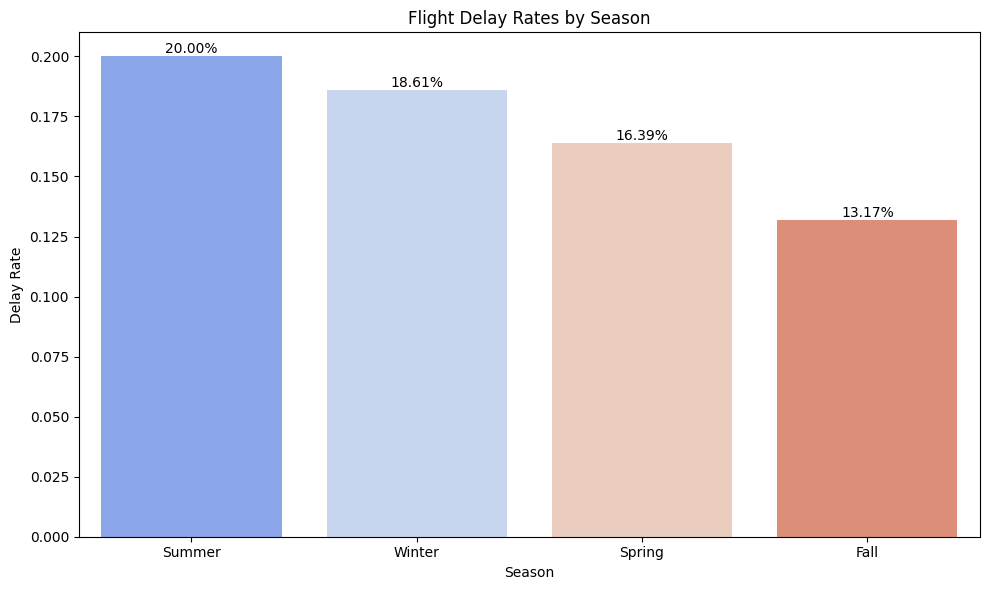

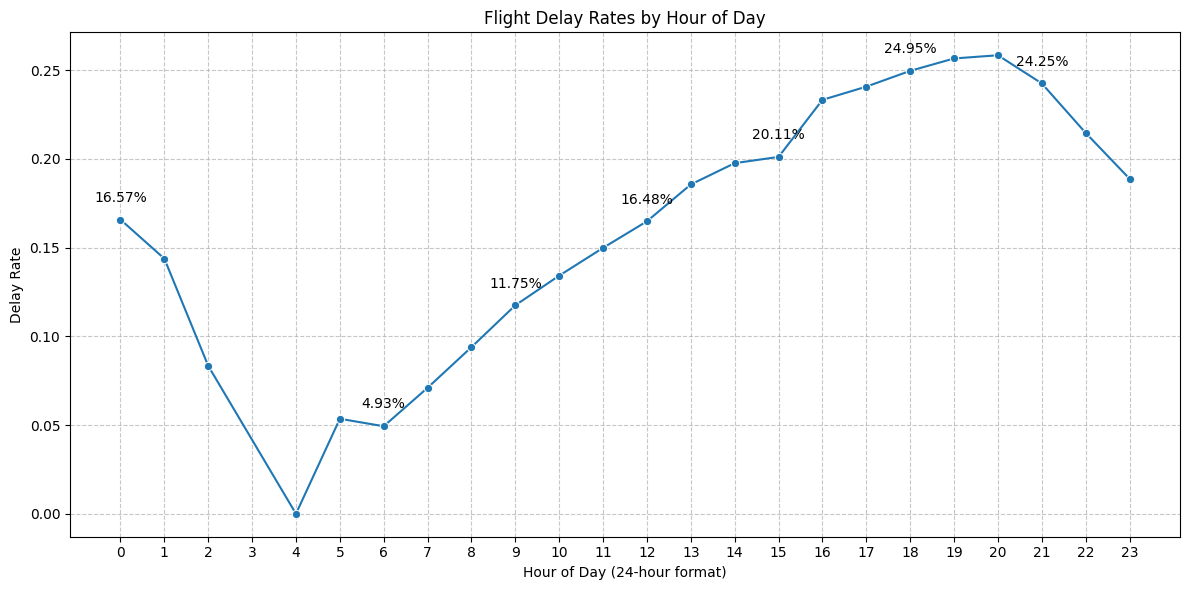


Best times to fly (lowest delay rates):
  4:00 - 0.00% delay rate
  6:00 - 4.93% delay rate
  5:00 - 5.35% delay rate

Worst times to fly (highest delay rates):
  20:00 - 25.83% delay rate
  19:00 - 25.65% delay rate
  18:00 - 24.95% delay rate

Top 5 Airlines (lowest delay rates):
  HA: 10.32%
  US: 13.25%
  AS: 13.60%
  DL: 14.13%
  MQ: 14.59%

Bottom 5 Airlines (highest delay rates):
  UA: 18.67%
  AA: 18.93%
  WN: 20.17%
  B6: 20.81%
  EV: 22.02%


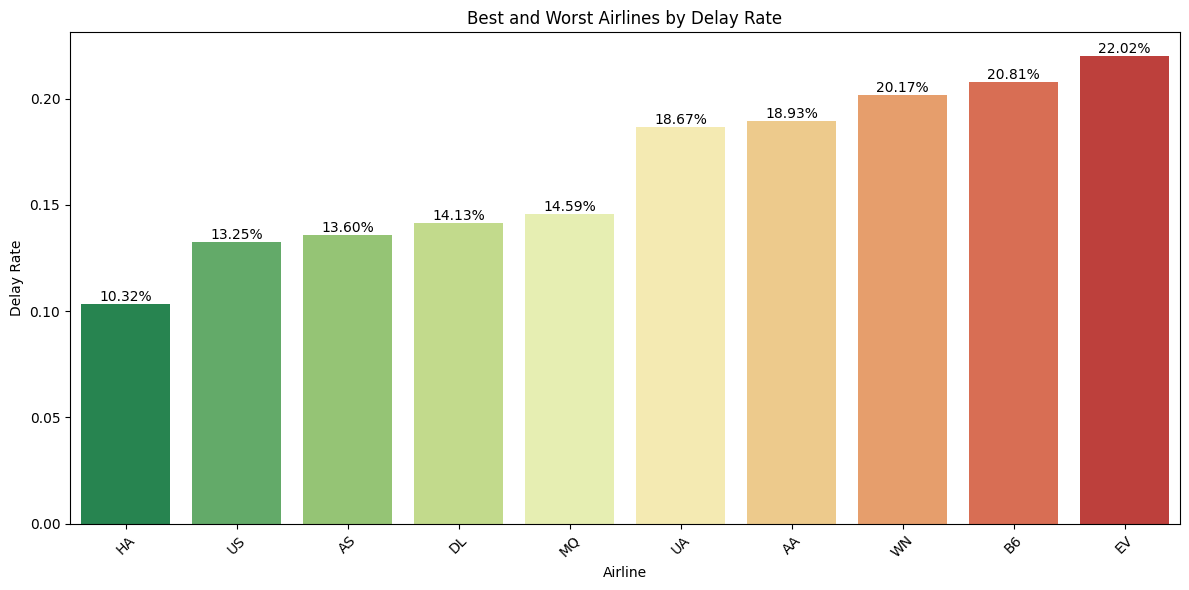


Extracting feature importance...

=== Top 10 Features ===
1. route_delay_rate: 0.2849
2. scheduledhour: 0.1908
3. time_of_day_Afternoon: 0.0803
4. time_of_day_Morning: 0.0717
5. time_of_day_Evening: 0.0661
6. windspeed: 0.0360
7. temperature: 0.0275
8. season_Summer: 0.0198
9. dest_EWR: 0.0144
10. distance: 0.0130


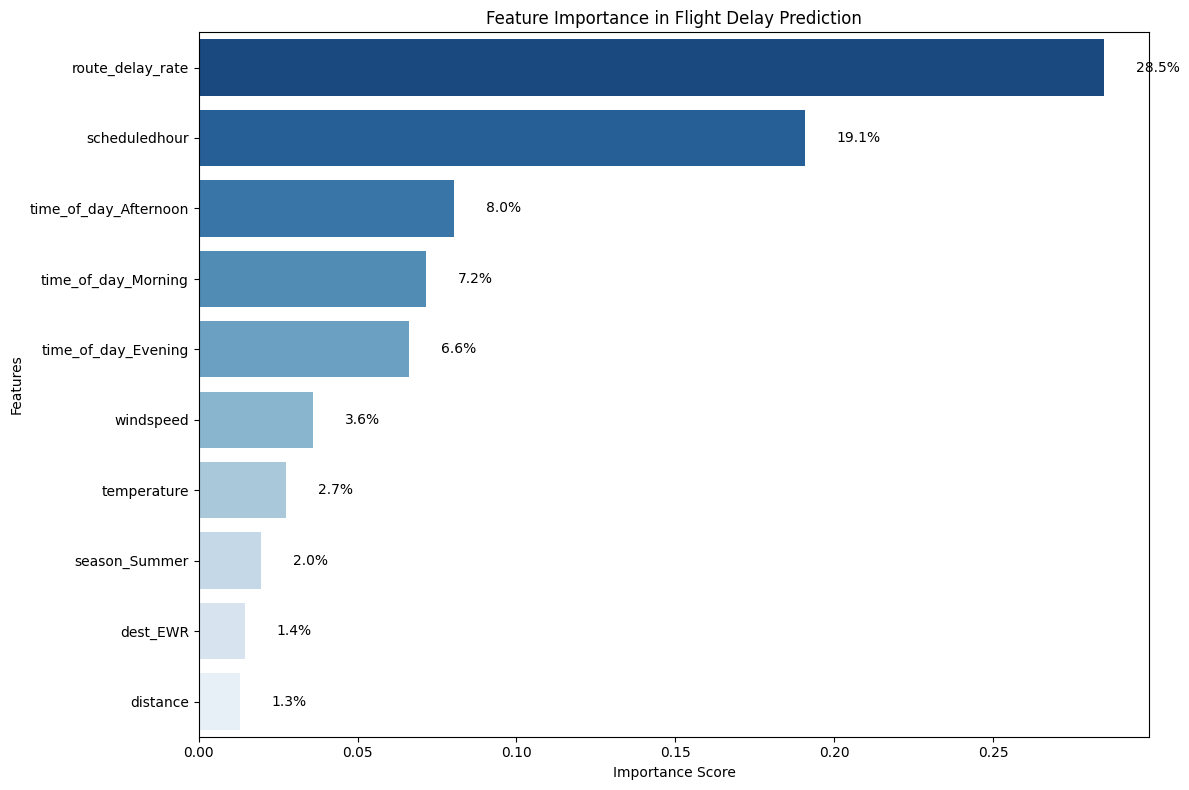


=== Training Logistic Regression ===
Logistic Regression Performance:
  Accuracy: 0.6713
  Precision: 0.2956
  Recall: 0.6705
  F1 Score: 0.4103
  ROC AUC Score: 0.7288

=== Training K-Nearest Neighbors ===
K-Nearest Neighbors Performance:
  Accuracy: 0.8135
  Precision: 0.3605
  Recall: 0.1204
  F1 Score: 0.1805
  ROC AUC Score: 0.6372

=== Training Random Forest ===
Random Forest Performance:
  Accuracy: 0.6770
  Precision: 0.2933
  Recall: 0.6334
  F1 Score: 0.4009
  ROC AUC Score: 0.7138

=== Training Gradient Boosting ===
Gradient Boosting Performance:
  Accuracy: 0.8327
  Precision: 0.6235
  Recall: 0.0493
  F1 Score: 0.0914
  ROC AUC Score: 0.7373

=== Training Decision Tree ===
Decision Tree Performance:
  Accuracy: 0.6134
  Precision: 0.2672
  Recall: 0.7265
  F1 Score: 0.3907
  ROC AUC Score: 0.7178

=== Training Naive Bayes ===
Naive Bayes Performance:
  Accuracy: 0.1916
  Precision: 0.1714
  Recall: 0.9753
  F1 Score: 0.2916
  ROC AUC Score: 0.5030

Best performing model (

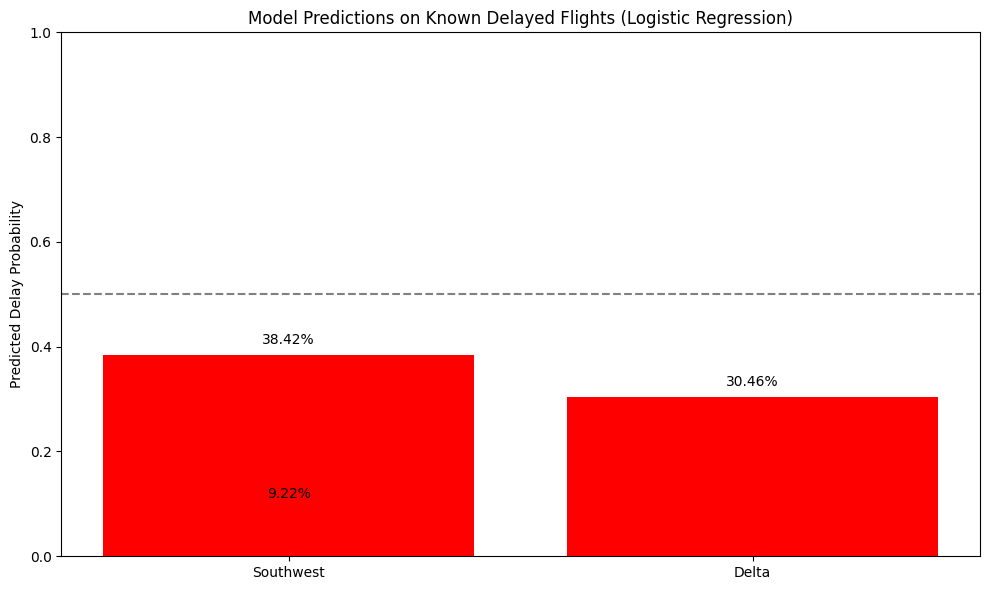

<Figure size 1200x600 with 0 Axes>

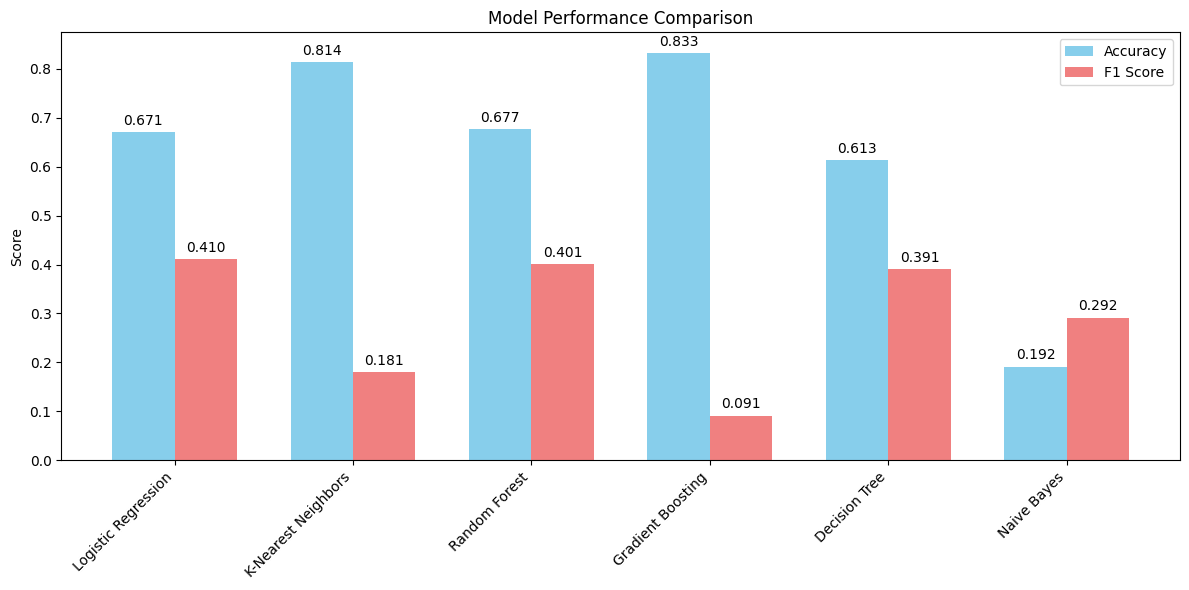

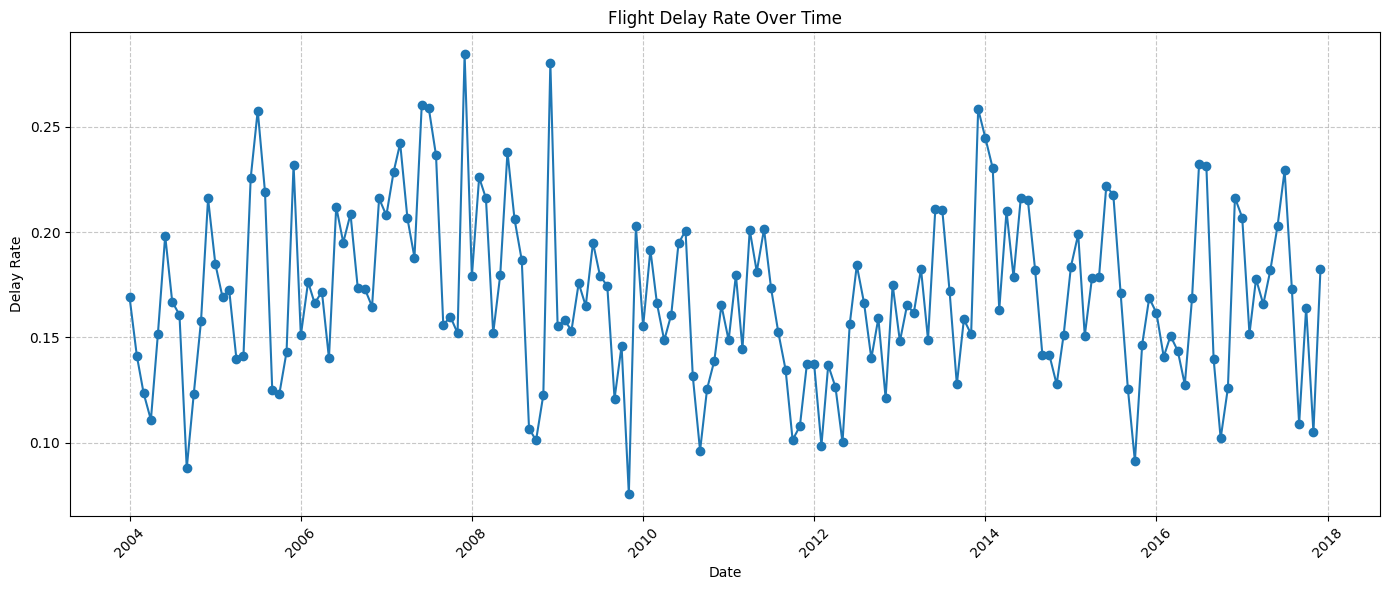


=== Final Model Performance Metrics ===
                     Accuracy  Precision  Recall  F1 Score
Logistic Regression    0.6713     0.2956  0.6705    0.4103
Random Forest          0.6770     0.2933  0.6334    0.4009
Decision Tree          0.6134     0.2672  0.7265    0.3907
Naive Bayes            0.1916     0.1714  0.9753    0.2916
K-Nearest Neighbors    0.8135     0.3605  0.1204    0.1805
Gradient Boosting      0.8327     0.6235  0.0493    0.0914


In [ ]:
#Minli Accuracy Improvement CODE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
import datetime
warnings.filterwarnings('ignore')

def comprehensive_flight_delay_prediction(data_path='DelayData.csv', sample_size=100000):
    # 1. Data Loading and Preprocessing
    print("=== Flight Delay Prediction System ===")

    # Load data
    df = pd.read_csv(data_path)
    df.columns = df.columns.str.lower()

    print(f"Original dataset size: {len(df)} rows")

    # More sophisticated sampling: ensure diversity across years, carriers and seasons
    if len(df) > sample_size:
        has_datetime = False
        if 'scheduleddepartdatetime' in df.columns:
            df['scheduleddepartdatetime'] = pd.to_datetime(df['scheduleddepartdatetime'], errors='coerce')
            df['year'] = df['scheduleddepartdatetime'].dt.year
            has_datetime = True
        elif 'year' in df.columns:
            has_datetime = True

        # Stratified sampling based on carrier and year
        if has_datetime and 'uniquecarrier' in df.columns:
            # Create a stratification column
            df['strat'] = df['uniquecarrier'] + '_' + df['year'].astype(str)

            # Get a list of all strata
            strata = df['strat'].unique()

            # Calculate samples per stratum
            samples_per_stratum = max(1, int(sample_size / len(strata)))

            # Sample from each stratum
            sampled_dfs = []
            for stratum in strata:
                stratum_df = df[df['strat'] == stratum]
                # If stratum is smaller than needed samples, take all rows
                if len(stratum_df) <= samples_per_stratum:
                    sampled_dfs.append(stratum_df)
                else:
                    sampled_dfs.append(stratum_df.sample(n=samples_per_stratum, random_state=42))

            # Combine all samples
            df = pd.concat(sampled_dfs)
            df = df.drop(columns=['strat'])

            print(f"Data stratified sampled to {len(df)} rows across {len(strata)} year-carrier combinations")
        else:
            # Fall back to random sampling
            df = df.sample(n=sample_size, random_state=42)
            print(f"Data randomly sampled to {sample_size} rows")

    # Create delay indicator
    if 'depdelay' not in df.columns:
        print("Error: 'depdelay' column not found")
        return

    # Modified delay threshold for better balance
    delay_threshold = 15
    df['isdelayed'] = (df['depdelay'] > delay_threshold).astype(int)
    print(f"Proportion of delayed flights: {df['isdelayed'].mean():.2%}")

    # Calculate the class weights for imbalance handling
    delay_proportion = df['isdelayed'].mean()
    class_weight = {0: delay_proportion, 1: 1 - delay_proportion}
    print(f"Class weights to handle imbalance: {class_weight}")

    # 2. Feature Engineering
    leak_cols = [col for col in df.columns if 'delay' in col.lower() and col != 'isdelayed']
    df = df.drop(columns=leak_cols)

    # Handle missing values more robustly
    for col in df.select_dtypes(include=np.number).columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())

    # Non-numeric columns
    for col in df.select_dtypes(exclude=np.number).columns:
        if col != 'isdelayed' and df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mode()[0])

    if 'month' in df.columns:
        df['season'] = df['month'].map({
            1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
            5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
            9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'
        })

    if 'dayofweek' in df.columns:
        df['weekend'] = df['dayofweek'].isin([6, 7]).astype(int)

    if 'origin' in df.columns and 'dest' in df.columns:
        route_delay = df.groupby(['origin', 'dest'])['isdelayed'].mean().reset_index()
        route_delay.columns = ['origin', 'dest', 'route_delay_rate']
        df = pd.merge(df, route_delay, on=['origin', 'dest'], how='left')
        df['route_delay_rate'] = df['route_delay_rate'].fillna(df['isdelayed'].mean())

    # Add time features
    if 'scheduledhour' in df.columns:
        # Binning hours into periods of day
        df['time_of_day'] = pd.cut(
            df['scheduledhour'],
            bins=[0, 6, 12, 18, 24],
            labels=['Night', 'Morning', 'Afternoon', 'Evening']
        )

    # 3. Enhanced Data Analysis - Seasonal Patterns
    print("\n=== Seasonal Delay Analysis ===")
    if 'season' in df.columns:
        season_delays = df.groupby('season')['isdelayed'].mean().sort_values(ascending=False)
        print("Delay rates by season:")
        for season, rate in season_delays.items():
            print(f"  {season}: {rate:.2%}")

        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=season_delays.index, y=season_delays.values, palette='coolwarm')
        plt.title('Flight Delay Rates by Season')
        plt.xlabel('Season')
        plt.ylabel('Delay Rate')

        # Add percentage labels on bars
        for i, p in enumerate(ax.patches):
            ax.annotate(f"{p.get_height():.2%}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    # Time of Day Analysis
    if 'scheduledhour' in df.columns:
        hour_delays = df.groupby('scheduledhour')['isdelayed'].mean()

        plt.figure(figsize=(12, 6))
        ax = sns.lineplot(x=hour_delays.index, y=hour_delays.values, marker='o')
        plt.title('Flight Delay Rates by Hour of Day')
        plt.xlabel('Hour of Day (24-hour format)')
        plt.ylabel('Delay Rate')
        plt.xticks(range(0, 24))
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add percentage labels at key points
        for i, v in hour_delays.items():
            if i % 3 == 0:  # Label every 3 hours to avoid crowding
                plt.text(i, v + 0.01, f"{v:.2%}", ha='center')

        plt.tight_layout()
        plt.show()

        # Find best and worst times to fly
        best_hours = hour_delays.nsmallest(3)
        worst_hours = hour_delays.nlargest(3)

        print("\nBest times to fly (lowest delay rates):")
        for hour, rate in best_hours.items():
            print(f"  {hour}:00 - {rate:.2%} delay rate")

        print("\nWorst times to fly (highest delay rates):")
        for hour, rate in worst_hours.items():
            print(f"  {hour}:00 - {rate:.2%} delay rate")

    # Carrier Analysis
    if 'uniquecarrier' in df.columns:
        # Only include carriers with at least 100 flights
        carrier_counts = df['uniquecarrier'].value_counts()
        valid_carriers = carrier_counts[carrier_counts >= 100].index

        carrier_df = df[df['uniquecarrier'].isin(valid_carriers)]
        carrier_delays = carrier_df.groupby('uniquecarrier')['isdelayed'].mean().sort_values()

        # Get top 5 and bottom 5 carriers
        top5_carriers = carrier_delays.head(5)
        bottom5_carriers = carrier_delays.tail(5)

        print("\nTop 5 Airlines (lowest delay rates):")
        for carrier, rate in top5_carriers.items():
            print(f"  {carrier}: {rate:.2%}")

        print("\nBottom 5 Airlines (highest delay rates):")
        for carrier, rate in bottom5_carriers.items():
            print(f"  {carrier}: {rate:.2%}")

        plt.figure(figsize=(12, 6))
        combined = pd.concat([top5_carriers, bottom5_carriers])
        ax = sns.barplot(x=combined.index, y=combined.values, palette='RdYlGn_r')
        plt.title('Best and Worst Airlines by Delay Rate')
        plt.xlabel('Airline')
        plt.ylabel('Delay Rate')
        plt.xticks(rotation=45)

        # Add percentage labels on bars
        for i, p in enumerate(ax.patches):
            ax.annotate(f"{p.get_height():.2%}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    # 4. Feature Selection
    categorical_features = ['season', 'uniquecarrier', 'origin', 'dest']
    if 'time_of_day' in df.columns:
        categorical_features.append('time_of_day')

    numerical_features = ['scheduledhour', 'distance', 'windspeed', 'temperature',
                         'weekend', 'route_delay_rate']

    categorical_features = [f for f in categorical_features if f in df.columns]
    numerical_features = [f for f in numerical_features if f in df.columns]

    # Preprocess data
    X_prep = df[categorical_features + numerical_features].copy()
    y = df['isdelayed']

    # Create dummy variables for categorical features
    for col in categorical_features:
        if col in X_prep.columns:
            dummies = pd.get_dummies(X_prep[col], prefix=col, drop_first=True)
            X_prep = pd.concat([X_prep, dummies], axis=1)
            X_prep = X_prep.drop(columns=[col])

    # Standardize numerical features
    for col in numerical_features:
        if col in X_prep.columns:
            scaler = StandardScaler()
            X_prep[col] = scaler.fit_transform(X_prep[[col]])

    # 5. Train Random Forest to get feature importance
    print("\nExtracting feature importance...")
    # Modified Random Forest parameters for better performance
    rf_for_importance = RandomForestClassifier(
        n_estimators=100,  # More trees
        max_depth=10,      # Deeper trees
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',  # Handle imbalance
        n_jobs=-1,
        random_state=42
    )
    rf_for_importance.fit(X_prep, y)

    # Get feature importances
    feature_importances = dict(zip(X_prep.columns, rf_for_importance.feature_importances_))
    feature_importances = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))

    # Get Top 10 features
    top_10_features = list(feature_importances.keys())[:10]
    print("\n=== Top 10 Features ===")
    for i, (feature, importance) in enumerate(list(feature_importances.items())[:10], 1):
        print(f"{i}. {feature}: {importance:.4f}")

    # 6. Plot feature importance
    plt.figure(figsize=(12, 8))
    features = list(feature_importances.keys())[:10]
    importances = list(feature_importances.values())[:10]
    sns.barplot(x=importances, y=features, palette='Blues_r')
    plt.title('Feature Importance in Flight Delay Prediction')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')

    # Add percentage values to the bars
    for i, imp in enumerate(importances):
        total_importance = sum(list(feature_importances.values()))
        percentage = imp / total_importance * 100
        plt.text(imp + 0.01, i, f'{percentage:.1f}%', va='center')

    plt.tight_layout()
    plt.show()

    # 7. Train-test split using the full feature set
    X_train, X_test, y_train, y_test = train_test_split(
        X_prep, y, test_size=0.2, random_state=42, stratify=y)

    # 8. Model definitions with two additional models and improved parameters
    models = {
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            C=0.1,  # Stronger regularization
            random_state=42
        ),
        'K-Nearest Neighbors': KNeighborsClassifier(
            n_neighbors=7,  # Slightly more neighbors
            weights='distance'  # Weight by distance for better performance
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=200,  # More trees
            max_depth=12,      # Deeper trees
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',  # Handle imbalance
            bootstrap=True,
            oob_score=True,  # Out-of-bag estimation
            n_jobs=-1,
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.05,  # Slower learning rate
            subsample=0.8,       # Use subsample for robustness
            random_state=42
        ),
        'Decision Tree': DecisionTreeClassifier(
            max_depth=8,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=42
        ),
        'Naive Bayes': GaussianNB()
    }

    # 9. Model training and evaluation with a focus on balanced evaluation
    results = {}
    roc_aucs = {}
    models_trained = {}
    all_predictions = {}
    all_probabilities = {}

    for model_name, model in models.items():
        print(f"\n=== Training {model_name} ===")

        model.fit(X_train, y_train)
        models_trained[model_name] = model

        y_pred = model.predict(X_test)
        all_predictions[model_name] = y_pred

        # Calculate and store metrics
        accuracy = accuracy_score(y_test, y_pred)
        results[model_name] = accuracy

        # Store probabilities
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            all_probabilities[model_name] = y_pred_proba
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            roc_aucs[model_name] = roc_auc
        else:
            all_probabilities[model_name] = y_pred
            roc_aucs[model_name] = 0.5

        # Print out more detailed metrics
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"{model_name} Performance:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")

        if 'roc_auc' in locals():
            print(f"  ROC AUC Score: {roc_auc:.4f}")

    # 10. Find best model
    best_model_f1s = {}

    for model_name, model in models_trained.items():
        y_pred = all_predictions[model_name]
        f1 = f1_score(y_test, y_pred, zero_division=0)
        best_model_f1s[model_name] = f1

    best_model_name = max(best_model_f1s, key=best_model_f1s.get)
    best_model = models_trained[best_model_name]

    print(f"\nBest performing model (by F1 Score): {best_model_name}")
    print(f"F1 Score: {best_model_f1s[best_model_name]:.4f}")
    print(f"Accuracy: {results[best_model_name]:.4f}")
    if best_model_name in roc_aucs:
        print(f"ROC AUC: {roc_aucs[best_model_name]:.4f}")

    # 11. Predict on recently confirmed delayed flights
    print("\n=== Testing Model on Known Delayed Flights ===")

    # First, calculate actual route_delay_rates from the data
    route_delay_lookup = df.groupby(['origin', 'dest'])['isdelayed'].mean().reset_index()
    route_delay_lookup.columns = ['origin', 'dest', 'route_delay_rate']

    # Create test flights with actual route delay rates
    known_delayed_flights = [
        {
            'scheduledhour': 21,             # 9:00 PM (WN606 scheduled departure time 21:05 CDT)
            'distance': 599,                 # MDW-RDU distance in miles
            'uniquecarrier': 'WN',           # Southwest Airlines
            'origin': 'MDW',                 # Chicago Midway
            'dest': 'RDU',                   # Raleigh-Durham
            'season': 'Spring',              # April = Spring
            'weekend': 1,                    # Sunday (2025-04-06)
            'temperature': 8.5,              # Weekly average temperature (Celsius)
            'windspeed': 14.5,               # Weekly average wind speed (km/h)
            'actual_delay': 'Delayed'        # Known to have been delayed
        },
        {
            'scheduledhour': 22,             # 10:00 PM (DL955 scheduled departure time 22:37 EDT)
            'distance': 356,                 # ATL-RDU distance in miles
            'uniquecarrier': 'DL',           # Delta Airlines
            'origin': 'ATL',                 # Atlanta
            'dest': 'RDU',                   # Raleigh-Durham
            'season': 'Spring',              # April = Spring
            'weekend': 0,                    # Monday (2025-04-07)
            'temperature': 22.7,             # Weekly average temperature
            'windspeed': 10.5,               # Weekly average wind speed
            'actual_delay': 'Delayed'        # Known to have been delayed
        },
        {
            'scheduledhour': 21,             # 9:00 PM (WN3976 scheduled departure time 21:40 CDT)
            'distance': 666,                 # STL-RDU distance in miles
            'uniquecarrier': 'WN',           # Southwest Airlines
            'origin': 'STL',                 # St. Louis
            'dest': 'RDU',                   # Raleigh-Durham
            'season': 'Spring',              # April = Spring
            'weekend': 1,                    # Sunday (2025-04-06)
            'temperature': 11.0,             # Weekly average temperature
            'windspeed': 15.0,               # Weekly average wind speed
            'actual_delay': 'Delayed'        # Known to have been delayed
        }
    ]

    # Add time_of_day
    if 'time_of_day' in df.columns:
        for flight in known_delayed_flights:
            hour = flight['scheduledhour']
            if 0 <= hour < 6:
                flight['time_of_day'] = 'Night'
            elif 6 <= hour < 12:
                flight['time_of_day'] = 'Morning'
            elif 12 <= hour < 18:
                flight['time_of_day'] = 'Afternoon'
            else:
                flight['time_of_day'] = 'Evening'

    # Dynamically look up and fill in the route_delay_rate for each test flight
    default_delay_rate = df['isdelayed'].mean()

    for flight in known_delayed_flights:
        matching_route = route_delay_lookup[
            (route_delay_lookup['origin'] == flight['origin']) &
            (route_delay_lookup['dest'] == flight['dest'])
        ]
        if not matching_route.empty:
            flight['route_delay_rate'] = matching_route['route_delay_rate'].values[0]
            print(f"Found actual route delay rate for {flight['origin']}-{flight['dest']}: {flight['route_delay_rate']:.3f}")
        else:
            flight['route_delay_rate'] = default_delay_rate
            print(f"No data for route {flight['origin']}-{flight['dest']}, using default rate: {default_delay_rate:.3f}")

    flight_descriptions = [
        "Southwest: 9:05 PM (MDW-RDU, WN606)",
        "Delta: 10:37 PM (ATL-RDU, DL955)",
        "Southwest: 9:40 PM (STL-RDU, WN3976)"
    ]

    # Create DataFrame
    flights_df = pd.DataFrame(known_delayed_flights)
    actual_outcomes = flights_df['actual_delay'].copy()
    flights_df = flights_df.drop(columns=['actual_delay'])

    # Create same feature format as model training
    flights_X = flights_df.copy()

    # Create dummy variables for categorical features
    for col in categorical_features:
        if col in flights_X.columns:
            dummies = pd.get_dummies(flights_X[col], prefix=col, drop_first=True)
            flights_X = pd.concat([flights_X, dummies], axis=1)
            flights_X = flights_X.drop(columns=[col])

    # Standardize numerical features
    for col in numerical_features:
        if col in flights_X.columns:
            scaler = StandardScaler()
            flights_X[col] = scaler.fit_transform(flights_X[[col]])

    # Ensure all training features exist
    for feature in X_train.columns:
        if feature not in flights_X.columns:
            flights_X[feature] = 0

    # Select only features in the training data
    flights_X = flights_X[X_train.columns]

    # Make predictions with best model only
    predictions = best_model.predict(flights_X)
    probabilities = best_model.predict_proba(flights_X)[:,1]

    # Create results table
    results_table = []
    for i, (desc, pred, prob, actual) in enumerate(zip(flight_descriptions, predictions, probabilities, actual_outcomes)):
        correct_prediction = (pred == 1 and actual == 'Delayed') or (pred == 0 and actual == 'On-time')

        results_table.append({
            'Flight': desc,
            'Actual Status': actual,
            'Predicted Status': 'Delayed' if pred == 1 else 'On-time',
            'Delay Probability': f"{prob:.2%}",
            'Correct Prediction': 'Yes' if correct_prediction else 'No'
        })

    # Display prediction results
    print(f"\n=== Flight Delay Predictions using {best_model_name} ===")
    print("\nTesting on Known Delayed Flights:")

    correct_count = 0
    for i, result in enumerate(results_table, 1):
        correct_count += 1 if result['Correct Prediction'] == 'Yes' else 0
        print(f"{i}. {result['Flight']}")
        print(f"   Actual Status: {result['Actual Status']}")
        print(f"   Predicted Status: {result['Predicted Status']}")
        print(f"   Delay Probability: {result['Delay Probability']}")
        print(f"   Correct Prediction? {result['Correct Prediction']}")
        print()

    accuracy = correct_count / len(results_table)
    print(f"Overall Accuracy on Known Delayed Flights: {accuracy:.2%}")

    # Plot prediction results
    plt.figure(figsize=(10, 6))

    # Extract airline names for plotting
    airlines = [desc.split(':')[0] for desc in flight_descriptions]

    # Create bar colors based on correct predictions
    bar_colors = ['green' if result['Correct Prediction'] == 'Yes' else 'red' for result in results_table]

    bars = plt.bar(airlines, probabilities, color=bar_colors)

    # Add probability labels on bars
    for bar, prob in zip(bars, probabilities):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f"{prob:.2%}", ha='center')

    plt.axhline(y=0.5, color='gray', linestyle='--', label='Delay Threshold')
    plt.ylabel('Predicted Delay Probability')
    plt.title(f'Model Predictions on Known Delayed Flights ({best_model_name})')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # Additional model comparison plot
    plt.figure(figsize=(12, 6))

    model_names = list(best_model_f1s.keys())
    accuracies = [results[name] for name in model_names]
    f1_scores = [best_model_f1s[name] for name in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
    rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightcoral')

    ax.set_title('Model Performance Comparison')
    ax.set_ylabel('Score')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.legend()

    # Add value labels to the bars
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)

    fig.tight_layout()
    plt.show()

    # Time series visualization
    if 'year' in df.columns and 'month' in df.columns:
        # Create a time series of delay rates
        df['yearmonth'] = df['year'].astype(int).astype(str) + '-' + df['month'].astype(int).astype(str).str.zfill(2)
        monthly_delays = df.groupby('yearmonth')['isdelayed'].mean().reset_index()
        monthly_delays['date'] = pd.to_datetime(monthly_delays['yearmonth'])
        monthly_delays = monthly_delays.sort_values('date')

        plt.figure(figsize=(14, 6))
        plt.plot(monthly_delays['date'], monthly_delays['isdelayed'], marker='o', linestyle='-')
        plt.title('Flight Delay Rate Over Time')
        plt.xlabel('Date')
        plt.ylabel('Delay Rate')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return {
        'best_model': best_model,
        'best_model_name': best_model_name,
        'feature_importances': feature_importances,
        'predictions': predictions,
        'probabilities': probabilities,
        'results_table': results_table,
        'model_accuracy_on_delayed': accuracy,
        'all_models_accuracy': results,
        'all_models_f1': best_model_f1s,
        'models_trained': models_trained,
        'X_test': X_test,
        'y_test': y_test
    }

# Call the function and capture outputs
results_dict = comprehensive_flight_delay_prediction()

models_trained = results_dict['models_trained']
X_test = results_dict['X_test']
y_test = results_dict['y_test']

# Compute extended metrics
extended_metrics = {}

for model_name, model in models_trained.items():
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    extended_metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Display as DataFrame
metrics_df = pd.DataFrame(extended_metrics).T.sort_values(by='F1 Score', ascending=False)
print("\n=== Final Model Performance Metrics ===")
print(metrics_df.round(4))